In [ ]:
#import libraries
import pandas as pd
import numpy as np   #pandas is built on numpy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, precision_score,recall_score, f1_score, confusion_matrix, accuracy_score, precision_recall_curve,average_precision_score)
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
import time
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
import sys
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = "/content/drive/MyDrive/2012dataset"

In [ ]:
file_paths={
    'Sat':f'{folder_path}/TestbedSatJun12Flows.csv',
    'Sun':f'{folder_path}/TestbedSunJun13Flows.csv',
    'Mon':f'{folder_path}/TestbedMonJun14Flows.csv',
    'Tue':f'{folder_path}/TestbedTueJun15Flows.csv',
    'Wed':f'{folder_path}/TestbedWedJun16Flows.csv',
    'Thu':f'{folder_path}/TestbedThuJun17Flows.csv'
} #dictionary
frames=[]
for day,path in file_paths.items():
    df_2012=pd.read_csv(path)
    df_2012['day']=day
    frames.append(df_2012)

df=pd.concat(frames,ignore_index=True)
pd.set_option('display.max_columns',None)

In [ ]:
session_df=['totalSourceBytes','totalDestinationBytes','totalSourcePackets','totalDestinationPackets','direction','sourceTCPFlagsDescription',
    'destinationTCPFlagsDescription','protocolName','sourcePort','destinationPort'] #drop time because it does not help the model according to SHAP
                                                                                    #analysis performed and over 83% are zero duration sessions
df=df[session_df+['Label','day']] #keeping day for more analysis later
df=df.copy()

In [ ]:
#packet ratio
df['packet_ratio']=df['totalSourcePackets']/df['totalDestinationPackets'].replace(0,np.nan)
df['packet_ratio']=df['packet_ratio'].fillna(0).clip(upper=10)

#byte ratio
df['byte_ratio']=df['totalSourceBytes']/df['totalDestinationBytes'].replace(0,np.nan)
df['byte_ratio']=df['byte_ratio'].fillna(0).clip(upper=10)

#average packet size source
df['avg_packet_size_src']=df['totalSourceBytes']/df['totalSourcePackets'].replace(0,np.nan)
df['avg_packet_size_src']=df['avg_packet_size_src'].fillna(0).clip(upper=1500)

#average packet size destination
df['avg_packet_size_dst']=df['totalDestinationBytes']/df['totalDestinationPackets'].replace(0,np.nan)
df['avg_packet_size_dst']=df['avg_packet_size_dst'].fillna(0).clip(upper=1500)

#bytes per packet
df['bytes_per_packet'] = (df['totalSourceBytes'] + df['totalDestinationBytes'])/(df['totalSourcePackets'] + df['totalDestinationPackets']).replace(0, np.nan)
df['bytes_per_packet'] =df['bytes_per_packet'].fillna(0).clip(upper=1500)

In [ ]:
df.head()

,totalSourceBytes,totalDestinationBytes,totalSourcePackets,totalDestinationPackets,direction,sourceTCPFlagsDescription,destinationTCPFlagsDescription,protocolName,sourcePort,destinationPort,Label,day,packet_ratio,byte_ratio,avg_packet_size_src,avg_packet_size_dst,bytes_per_packet
0,128,64,2,1,L2R,"F,A","F,A",tcp_ip,22441,80,Normal,Sat,2.000000,2.000000,64.000000,64.000000,64.000000
1,128,64,2,1,L2R,"F,A","F,A",tcp_ip,22445,80,Normal,Sat,2.000000,2.000000,64.000000,64.000000,64.000000
2,128,64,2,1,L2R,"F,A","F,A",tcp_ip,22444,80,Normal,Sat,2.000000,2.000000,64.000000,64.000000,64.000000
3,2938,49570,27,76,L2L,"S,R,P,A","S,P,A",tcp_ip,3248,22,Normal,Sat,0.355263,0.059270,108.814815,652.236842,509.786408
4,644,2315,7,5,L2R,"S,P,A","S,P,A",tcp_ip,1867,80,Normal,Sat,1.400000,0.278186,92.000000,463.000000,246.583333


In [ ]:
df.tail()

,totalSourceBytes,totalDestinationBytes,totalSourcePackets,totalDestinationPackets,direction,sourceTCPFlagsDescription,destinationTCPFlagsDescription,protocolName,sourcePort,destinationPort,Label,day,packet_ratio,byte_ratio,avg_packet_size_src,avg_packet_size_dst,bytes_per_packet
2071652,426,808,5,5,L2R,"F,S,P,A","F,S,P,A",tcp_ip,4077,80,Normal,Thu,1.000000,0.527228,85.200000,161.600000,123.400000
2071653,2526,92483,38,65,L2R,"F,S,P,A","F,S,P,A",tcp_ip,4078,80,Normal,Thu,0.584615,0.027313,66.473684,1422.815385,922.417476
2071654,310,130,3,2,L2R,"S,P,A","S,A",tcp_ip,4079,80,Normal,Thu,1.500000,2.384615,103.333333,65.000000,88.000000
2071655,426,808,5,5,L2R,"F,S,P,A","F,S,P,A",tcp_ip,4080,80,Normal,Thu,1.000000,0.527228,85.200000,161.600000,123.400000
2071656,624,7431,8,8,L2R,"S,P,A","S,P,A",tcp_ip,4081,80,Normal,Thu,1.000000,0.083973,78.000000,928.875000,503.437500


In [ ]:
df.dtypes

,0
totalSourceBytes,int64
totalDestinationBytes,int64
totalSourcePackets,int64
totalDestinationPackets,int64
direction,object
sourceTCPFlagsDescription,object
destinationTCPFlagsDescription,object
protocolName,object
sourcePort,int64
destinationPort,int64


In [ ]:
df.describe()

,totalSourceBytes,totalDestinationBytes,totalSourcePackets,totalDestinationPackets,sourcePort,destinationPort,packet_ratio,byte_ratio,avg_packet_size_src,avg_packet_size_dst,bytes_per_packet
count,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06
mean,2.460947e+03,3.448911e+04,1.984019e+01,3.030068e+01,1.413759e+04,1.882091e+03,8.963556e-01,3.627887e-01,8.485923e+01,4.857326e+02,3.157876e+02
std,7.517785e+05,1.187177e+06,6.679018e+02,9.834982e+02,2.014297e+04,8.623280e+03,4.704839e-01,5.328998e-01,3.443784e+01,4.493927e+02,2.660675e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.400000e+01
25%,2.560000e+02,4.190000e+02,3.000000e+00,2.000000e+00,2.302000e+03,8.000000e+01,6.600000e-01,5.170012e-02,7.250000e+01,1.418000e+02,1.190000e+02
50%,4.420000e+02,1.177000e+03,6.000000e+00,5.000000e+00,3.744000e+03,8.000000e+01,1.000000e+00,2.051937e-01,7.853333e+01,2.920000e+02,1.953846e+02
75%,8.450000e+02,7.338000e+03,1.000000e+01,1.100000e+01,1.699300e+04,8.000000e+01,1.000000e+00,4.801085e-01,9.000000e+01,7.860000e+02,4.580580e+02
max,7.632776e+08,1.254005e+09,5.147940e+05,8.722240e+05,6.553500e+04,6.553500e+04,1.000000e+01,1.000000e+01,1.500000e+03,1.500000e+03,1.500000e+03


In [ ]:
#Create directory
os.makedirs("eda_outputs", exist_ok=True)

#Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

#Calculate skewness
skewness = df_numeric.skew().sort_values(ascending=False)

skewness.to_csv("eda_outputs/skewness_before_log.csv")
print("Skewness stats saved")

# Identify highly skewed columns
skew_threshold = 1
skewed_cols = skewness[abs(skewness) > skew_threshold].index.tolist()
print("Highly skewed columns (|skew| > 1):", skewed_cols)

# Sample for plot
sample_size = 10000
df_plot_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

# Visualise before transformation
for col in skewed_cols:
    sns.histplot(df_plot_sample[col].dropna(), kde=True)
    plt.title(f"Before log1p transform: {col}")
    plt.savefig(f"eda_outputs/before_log_{col}.png")
    plt.close()

# Log transformation
df_log_transformed = df.copy()
transformed_cols = []

for col in skewed_cols:
    col_data = df_log_transformed[col]
    if col_data.min() < 0:
        print(f"Skipping {col} (contains negative values)")
        continue
    df_log_transformed[col] = np.log1p(col_data)
    transformed_cols.append(col)

# Sample for plot
df_log_sample = df_log_transformed.sample(n=min(sample_size, len(df)), random_state=42)

# Visualise after transformation
for col in transformed_cols:
    sns.histplot(df_log_sample[col].dropna(), kde=True)
    plt.title(f"After log1p transform: {col}")
    plt.savefig(f"eda_outputs/after_log_{col}.png")
    plt.close()

# Save transformed column names
pd.Series(transformed_cols, name="log1p_transformed_columns").to_csv("eda_outputs/log1p_transformed_columns.csv", index=False)
print("Transformation complete")

Skewness stats saved
Highly skewed columns (|skew| > 1): ['totalSourceBytes', 'totalDestinationBytes', 'totalSourcePackets', 'totalDestinationPackets', 'avg_packet_size_src', 'byte_ratio', 'destinationPort', 'packet_ratio', 'sourcePort', 'bytes_per_packet']
Transformation complete


In [ ]:
missing_counts=df.isnull().sum()
print("Missing counts per column: \n",missing_counts)

Missing counts per column: 
 totalSourceBytes                       0
totalDestinationBytes                  0
totalSourcePackets                     0
totalDestinationPackets                0
direction                              0
sourceTCPFlagsDescription         430943
destinationTCPFlagsDescription    493422
protocolName                           0
sourcePort                             0
destinationPort                        0
Label                                  0
day                                    0
packet_ratio                           0
byte_ratio                             0
avg_packet_size_src                    0
avg_packet_size_dst                    0
bytes_per_packet                       0
dtype: int64


In [ ]:
# Missing by Label
total_by_label = df.groupby('Label').size()
missing_by_label = df[df.isnull().any(axis=1)].groupby('Label').size()

missing_summary_label = pd.DataFrame({'total_count': total_by_label,'missing_count': missing_by_label,})
missing_summary_label['missing_percentage'] = (missing_summary_label['missing_count'] / missing_summary_label['total_count'] * 100).round(2)

print("Missing values summary by Label:")
print(missing_summary_label.fillna(0))

# Missing by Day
total_by_day = df.groupby('day').size()
missing_by_day = df[df.isnull().any(axis=1)].groupby('day').size()

missing_summary_day = pd.DataFrame({'total_count': total_by_day,'missing_count': missing_by_day,})
missing_summary_day['missing_percentage'] = (missing_summary_day['missing_count'] / missing_summary_day['total_count'] * 100).round(2)

print("\nMissing values summary by Day:")
print(missing_summary_day.fillna(0))

Missing values summary by Label:
        total_count  missing_count  missing_percentage
Label                                                 
Attack        68910           2351                3.41
Normal      2002747         494411               24.69

Missing values summary by Day:
     total_count  missing_count  missing_percentage
day                                                
Mon       171380          54207               31.63
Sat       133193          42507               31.91
Sun       275528          62810               22.80
Thu       397595          86681               21.80
Tue       571698         149848               26.21
Wed       522263         100709               19.28


In [ ]:
cat_cols=['direction','sourceTCPFlagsDescription','destinationTCPFlagsDescription','protocolName']
for col in cat_cols:
    df[col] = df[col].fillna("UNKNOWN")

label_encoders = {}
label_mappings = {}

for col in cat_cols:
    le = LabelEncoder()
    df[ col] = le.fit_transform(df[col])
    label_encoders[col] = le
    label_mappings[col] = dict(zip(le.transform(le.classes_), le.classes_))

for col, mapping in label_mappings.items():
    mapping_df = pd.DataFrame(list(mapping.items()), columns=['Code', 'Category'])
    mapping_df.to_csv(f"eda_outputs/{col}_label_mapping.csv", index=False)

print(df.dtypes)
print("Mappings completed.")

totalSourceBytes                    int64
totalDestinationBytes               int64
totalSourcePackets                  int64
totalDestinationPackets             int64
direction                           int64
sourceTCPFlagsDescription           int64
destinationTCPFlagsDescription      int64
protocolName                        int64
sourcePort                          int64
destinationPort                     int64
Label                              object
day                                object
packet_ratio                      float64
byte_ratio                        float64
avg_packet_size_src               float64
avg_packet_size_dst               float64
bytes_per_packet                  float64
dtype: object
Mappings completed.


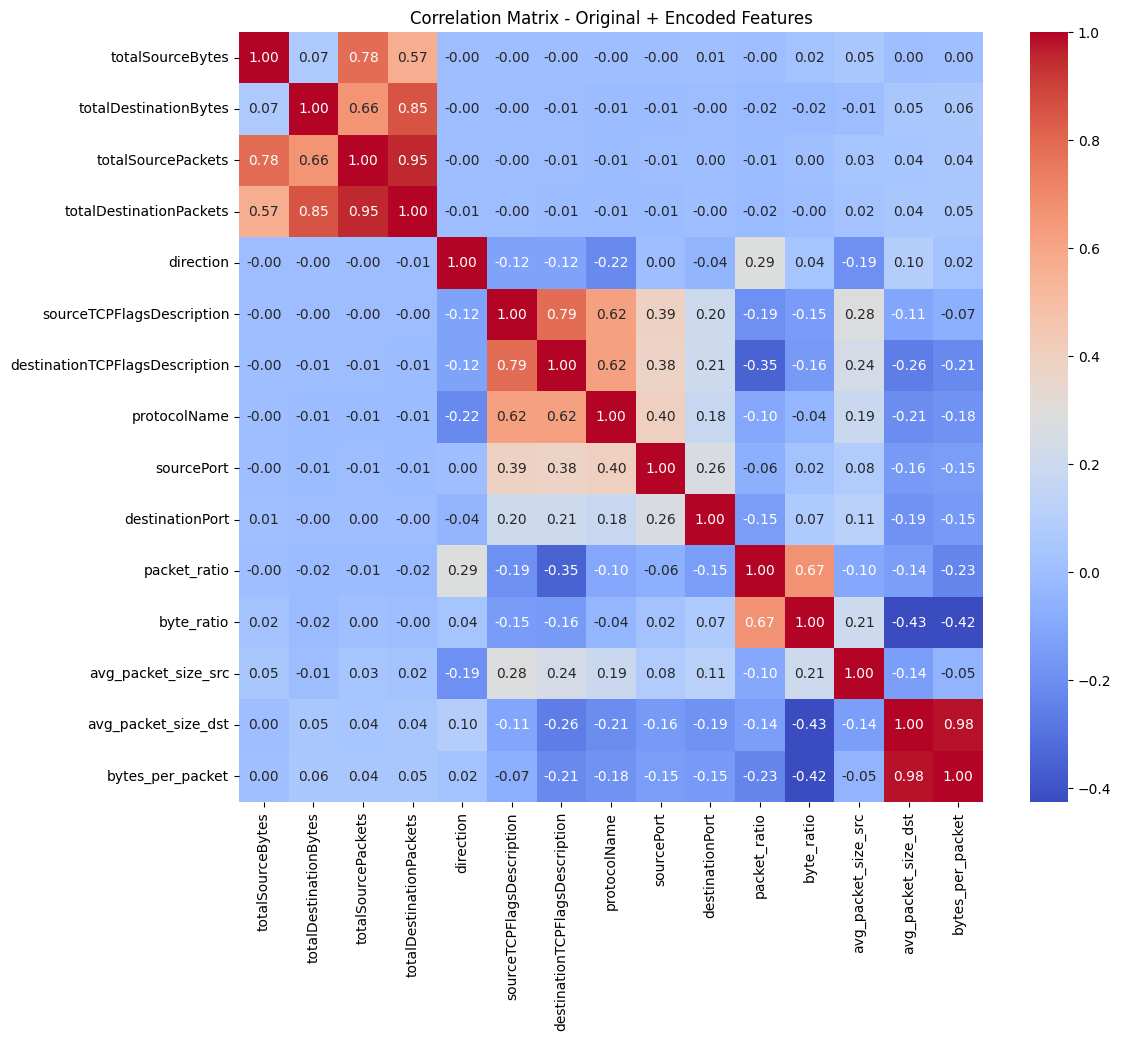

In [ ]:
# Correlation matrix on original columns
numeric_cols = df.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Original + Encoded Features")
plt.show()
corr_matrix.to_csv("eda_outputs/correlation_matrix_original.csv")

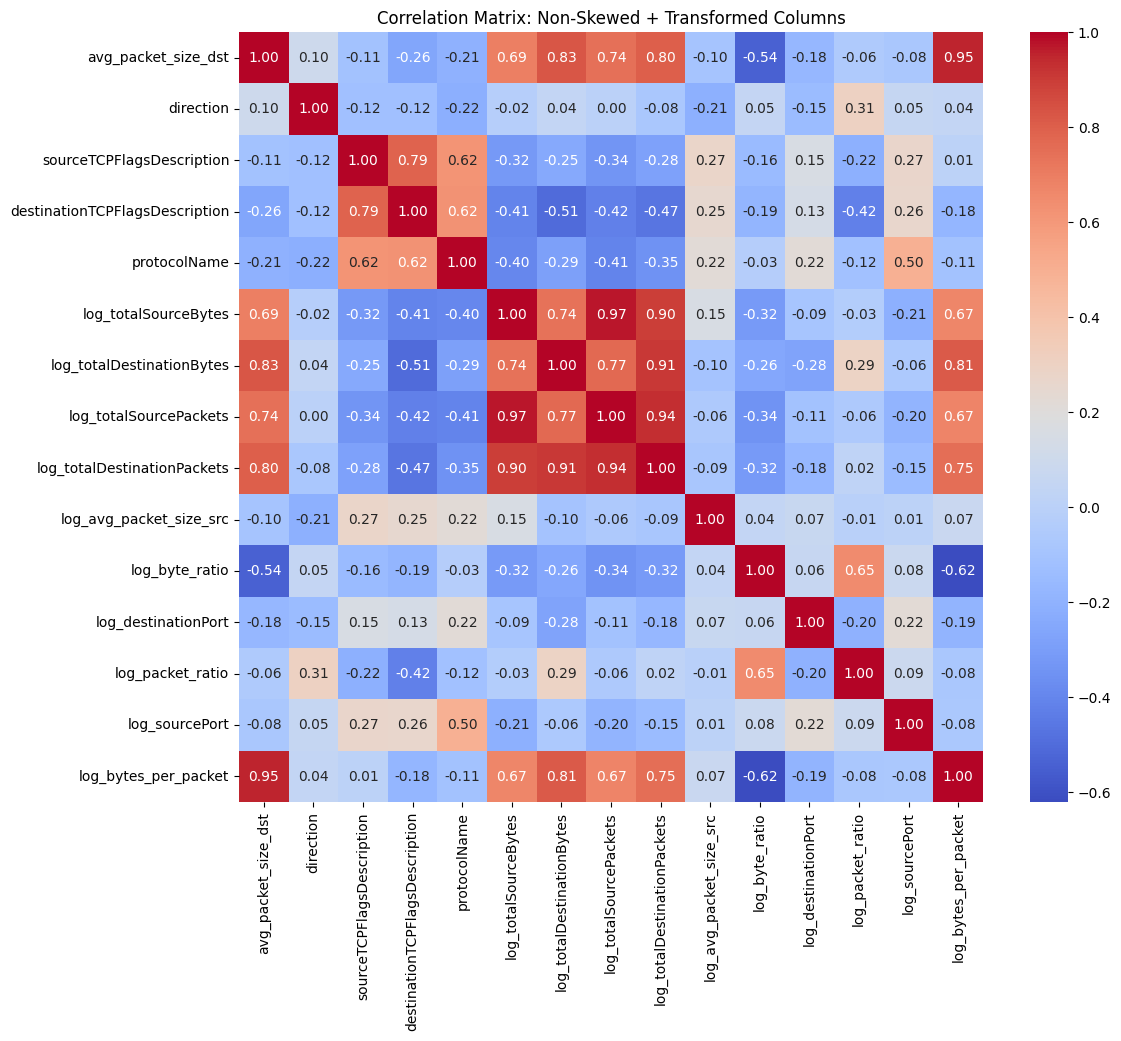

In [ ]:
# Correlation matrix on skewed columns
non_skewed_cols = [col for col in df_numeric.columns if col not in skewed_cols]
encoded_cols = ['direction','sourceTCPFlagsDescription','destinationTCPFlagsDescription','protocolName']
df_improved = df[non_skewed_cols+encoded_cols].copy()

# Add log-transformed versions of skewed columns
for col in transformed_cols:
    df_improved[f"log_{col}"] = np.log1p(df[col].clip(lower=0))

# Compute correlation matrix
corr_matrix_improved = df_improved.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_improved, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Non-Skewed + Transformed Columns")
plt.show()
corr_matrix_improved.to_csv("eda_outputs/correlation_matrix_improved.csv")



In [ ]:
def drop_highly_correlated(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation above threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)

    print(f"Dropped {len(to_drop)} columns due to high correlation: {to_drop}")
    return df_reduced

In [ ]:
# Apply to original dataset
df_numeric = df.select_dtypes(include=np.number)
df_reduced = drop_highly_correlated(df_numeric)
df_model_original = pd.concat([df_reduced, df["Label"]], axis=1)

Dropped 2 columns due to high correlation: ['totalDestinationPackets', 'bytes_per_packet']


In [ ]:
# Apply to improved dataset
df_improved_numeric = df_improved.select_dtypes(include=np.number)
df_improved_reduced = drop_highly_correlated(df_improved_numeric)
df_model_improved = pd.concat([df_improved_reduced, df["Label"]], axis=1)

Dropped 2 columns due to high correlation: ['log_totalSourcePackets', 'log_bytes_per_packet']



Baseline Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400550
           1       0.99      0.99      0.99     13782

    accuracy                           1.00    414332
   macro avg       0.99      0.99      0.99    414332
weighted avg       1.00      1.00      1.00    414332

AUC: 0.9994
Average Precision: 0.9946


<Figure size 800x600 with 0 Axes>

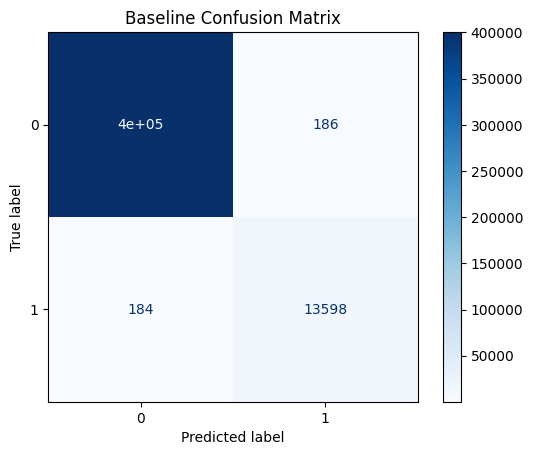


Class Weighted Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400550
           1       0.99      0.99      0.99     13782

    accuracy                           1.00    414332
   macro avg       0.99      0.99      0.99    414332
weighted avg       1.00      1.00      1.00    414332

AUC: 0.9994
Average Precision: 0.9945


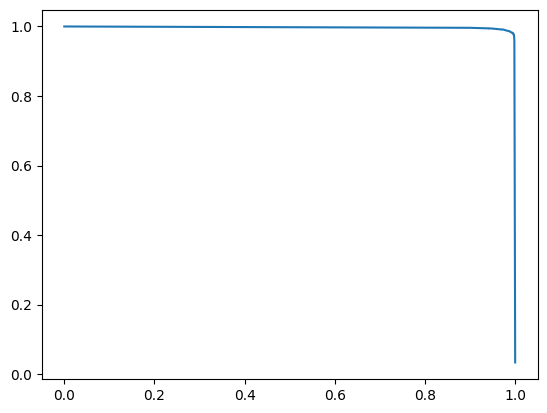

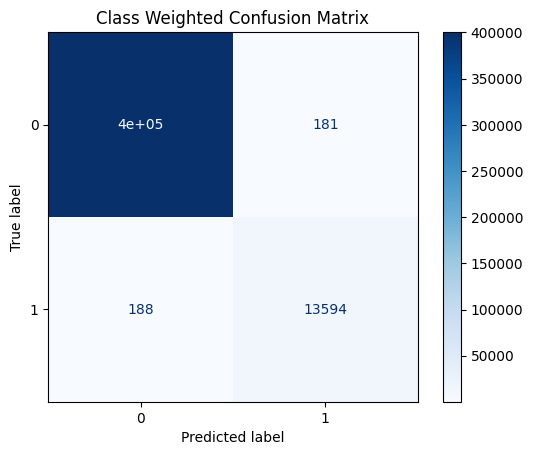


SMOTE Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400550
           1       0.98      0.99      0.99     13782

    accuracy                           1.00    414332
   macro avg       0.99      1.00      0.99    414332
weighted avg       1.00      1.00      1.00    414332

AUC: 0.9994
Average Precision: 0.9899


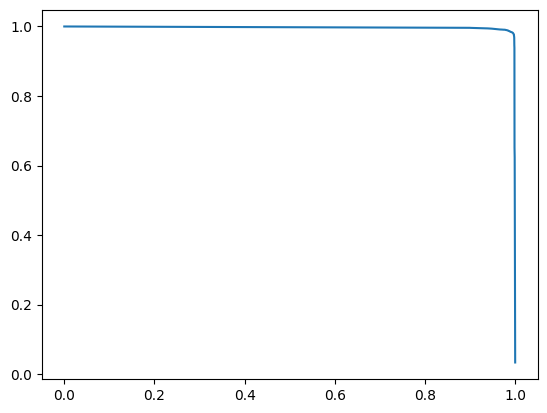

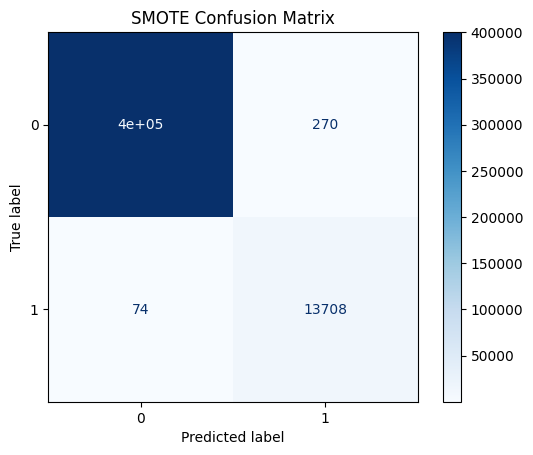

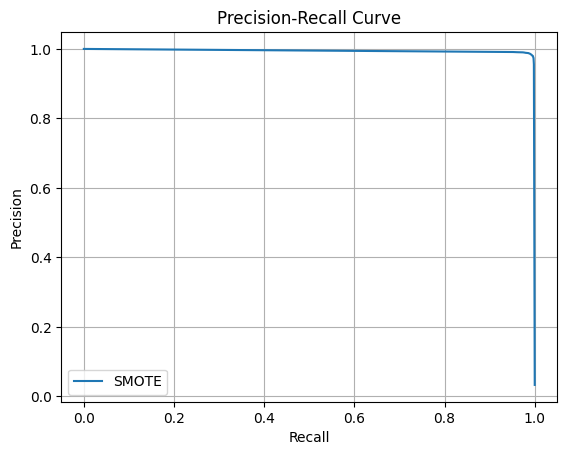

In [ ]:
X = df_model_original.drop("Label", axis=1)
y = df_model_original["Label"].map({"Normal": 0, "Attack": 1})

def benchmark_models(X, y, model_type='rf', random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

    # SMOTE
    smote = SMOTE(random_state=random_state)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Define models
    models = {
        'Baseline': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'Class Weighted': RandomForestClassifier(class_weight='balanced', random_state=random_state, n_jobs=-1),
        'SMOTE': RandomForestClassifier(random_state=random_state, n_jobs=-1)
    }

    # Fit models
    models['Baseline'].fit(X_train, y_train)
    models['Class Weighted'].fit(X_train, y_train)
    models['SMOTE'].fit(X_train_smote, y_train_smote)

    # Evaluate
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred))
        print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"{name} Confusion Matrix")
        plt.show()

        # PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=name)

    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

benchmark_models(X, y)

In [ ]:
def compare_models_cv(models, X, y, scoring=None, cv=5, verbose=True):

    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    results = {}
    for name, model in models.items():
        cv_result = cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=False)
        mean_scores = {metric: round(cv_result[f'test_{metric}'].mean(), 4) for metric in scoring}
        results[name] = mean_scores
        if verbose:
            print(f"\n{name} scores:")
            for metric, score in mean_scores.items():
                print(f"  {metric}: {score}")

    return pd.DataFrame(results).T

In [ ]:
# Define models
rf_params = {
    'n_estimators': 50,
    'max_depth': 15,
    'n_jobs': -1,
    'random_state': 42
}

models = {
    "Baseline RF": RandomForestClassifier(**rf_params),
    "Weighted RF": RandomForestClassifier(class_weight='balanced', **rf_params),
    "SMOTE + RF": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(**rf_params))
    ])
}

# Run cross-validation comparison
cv_summary = compare_models_cv(models, X, y)

# Optional: display as table
print("\nCross-validation summary:")
print(cv_summary)


Baseline RF scores:
  accuracy: 0.9925
  precision: 0.9154
  recall: 0.8866
  f1: 0.8889
  roc_auc: 0.9898

Weighted RF scores:
  accuracy: 0.9911
  precision: 0.912
  recall: 0.8469
  f1: 0.8594
  roc_auc: 0.9869

SMOTE + RF scores:
  accuracy: 0.9906
  precision: 0.8375
  recall: 0.9208
  f1: 0.869
  roc_auc: 0.9935

Cross-validation summary:
             accuracy  precision  recall      f1  roc_auc
Baseline RF    0.9925     0.9154  0.8866  0.8889   0.9898
Weighted RF    0.9911     0.9120  0.8469  0.8594   0.9869
SMOTE + RF     0.9906     0.8375  0.9208  0.8690   0.9935



Baseline Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400550
           1       0.99      0.99      0.99     13782

    accuracy                           1.00    414332
   macro avg       0.99      0.99      0.99    414332
weighted avg       1.00      1.00      1.00    414332

AUC: 0.9994
Average Precision: 0.9947


<Figure size 800x600 with 0 Axes>

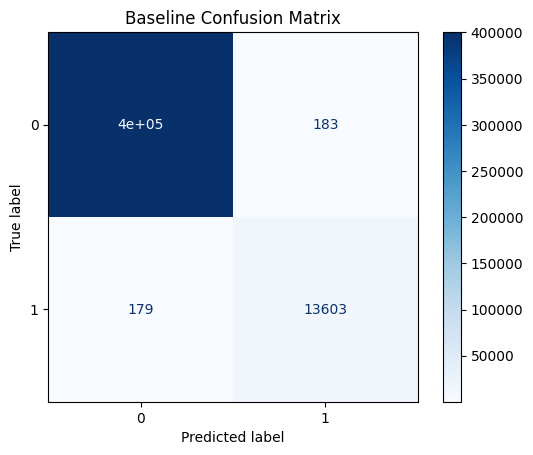


Class Weighted Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400550
           1       0.99      0.99      0.99     13782

    accuracy                           1.00    414332
   macro avg       0.99      0.99      0.99    414332
weighted avg       1.00      1.00      1.00    414332

AUC: 0.9993
Average Precision: 0.9944


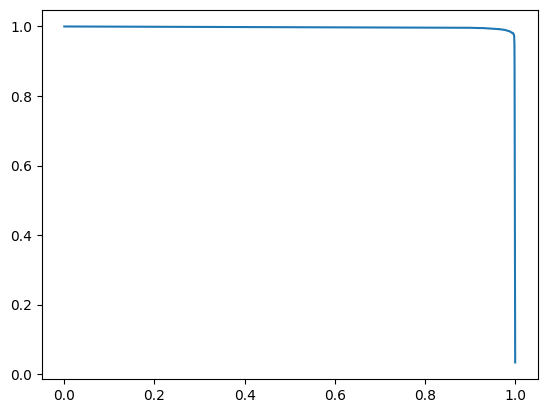

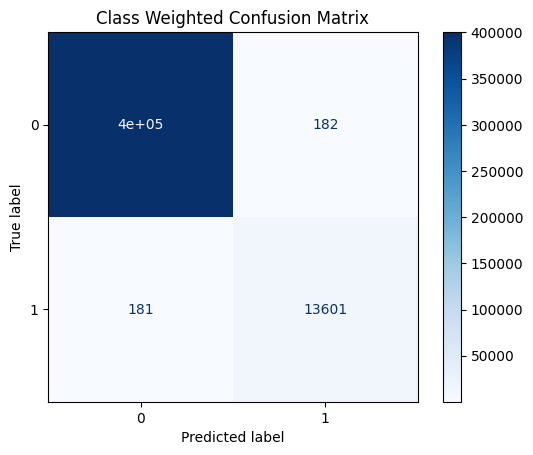


SMOTE Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400550
           1       0.98      0.99      0.99     13782

    accuracy                           1.00    414332
   macro avg       0.99      1.00      0.99    414332
weighted avg       1.00      1.00      1.00    414332

AUC: 0.9993
Average Precision: 0.9895


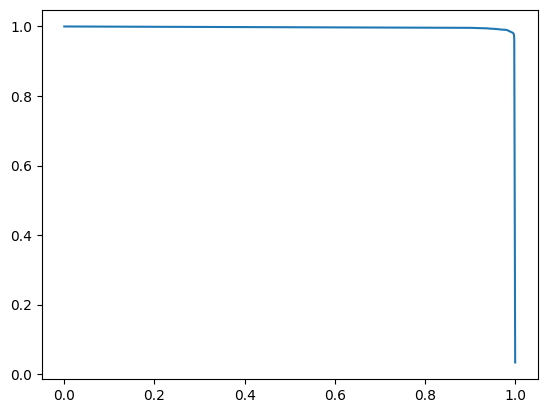

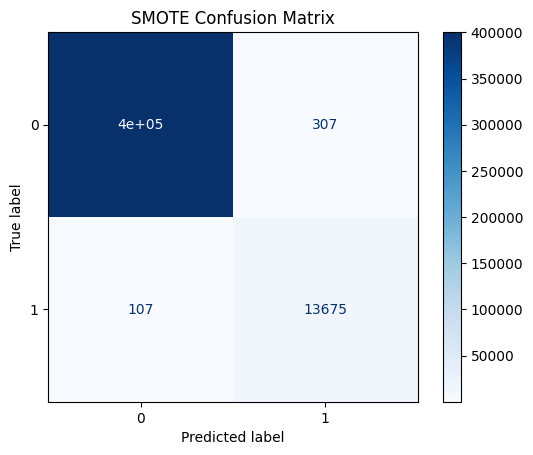

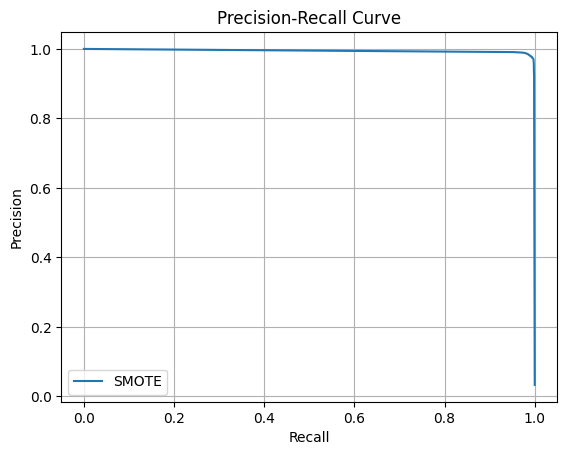

Benchmark completed in 1861.08 seconds


In [ ]:
X = df_model_improved.drop("Label", axis=1)
y = df_model_improved["Label"].map({"Normal": 0, "Attack": 1})

def benchmark_models(X, y, model_type='rf', random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

    # SMOTE
    smote = SMOTE(random_state=random_state)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Define models
    models = {
        'Baseline': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'Class Weighted': RandomForestClassifier(class_weight='balanced', random_state=random_state, n_jobs=-1),
        'SMOTE': RandomForestClassifier(random_state=random_state, n_jobs=-1)
    }

    # Fit models
    models['Baseline'].fit(X_train, y_train)
    models['Class Weighted'].fit(X_train, y_train)
    models['SMOTE'].fit(X_train_smote, y_train_smote)

    # Evaluate
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred))
        print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"{name} Confusion Matrix")
        plt.show()

        # PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=name)

    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

start = time.time()
benchmark_models(X, y)
print(f"Benchmark completed in {time.time() - start:.2f} seconds")

In [ ]:
# Define models
models = {
    "Baseline RF": RandomForestClassifier(random_state=42),
    "Weighted RF": RandomForestClassifier(class_weight='balanced', random_state=42),
    "SMOTE + RF": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])
}

# Run cross-validation comparison
cv_summary = compare_models_cv(models, X, y)

# Optional: display as table
print("\nCross-validation summary:")
print(cv_summary)


Baseline RF scores:
  accuracy: 0.9923
  precision: 0.9187
  recall: 0.8761
  f1: 0.8841
  roc_auc: 0.9843

Weighted RF scores:
  accuracy: 0.9904
  precision: 0.9246
  recall: 0.8167
  f1: 0.8412
  roc_auc: 0.9831

SMOTE + RF scores:
  accuracy: 0.9912
  precision: 0.8807
  recall: 0.8898
  f1: 0.8715
  roc_auc: 0.9883

Cross-validation summary:
             accuracy  precision  recall      f1  roc_auc
Baseline RF    0.9923     0.9187  0.8761  0.8841   0.9843
Weighted RF    0.9904     0.9246  0.8167  0.8412   0.9831
SMOTE + RF     0.9912     0.8807  0.8898  0.8715   0.9883
